In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linear_models import LinearBinaryClassifier, LinearOneVsAllClassifier
from noise_functions_multiclass import tryRegionOneVsAll
import time
%matplotlib inline

In [2]:
def optTargetedNoiseMulti(model, X, Targets, alpha):
    n = X.shape[0]
    noise = []
    # iterate over all points
    for i in xrange(n):
        v = tryRegionOneVsAll([model], [Targets[i]], X[i])
        norm = np.linalg.norm(v)
        if norm < alpha:
            res = v
        else:
            res = np.zeros(28*28)
        noise.append(res)
    return np.array(noise)

In [3]:
folders = ['randomAscent', 'greedyAscent', 'gradientDescent']

In [4]:
data_path = "multiclass_data_2"
models = []
exp_type = "multiclass"
num_classifiers = 5
alpha = .5

X_exp = np.load(data_path + "/" + "X_exp.npy")
Target_exp = np.load(data_path + "/" + "Target_exp.npy")

for i in xrange(num_classifiers):
    weights = np.load(data_path + "/" + "weights_{}.npy".format(i))
    bias = np.load(data_path + "/" + "bias_{}.npy".format(i))
    model = LinearOneVsAllClassifier(10, weights, bias)
    models.append(model)

In [5]:
ensemble_weights = sum([1.0 / num_classifiers * model.weights for model in models ])
ensemble_bias = sum([1.0 / num_classifiers * model.bias for model in models ])
ensemble_model = LinearOneVsAllClassifier(10, ensemble_weights, ensemble_bias)

In [6]:
def normalize(noise, alpha):
    for i in range(noise.shape[0]):
        norm = np.linalg.norm(noise[i])
        if norm > 0:
            noise[i] = noise[i] / norm * alpha
    return noise

In [7]:
ensemble_noise = optTargetedNoiseMulti(ensemble_model, X_exp, Target_exp, alpha)
ensemble_noise = normalize(ensemble_noise, alpha)

In [8]:
individual_noise = [optTargetedNoiseMulti(model, X_exp, Target_exp, alpha) for model in models]
individual_noise = [normalize(noise, alpha) for noise in individual_noise]

In [12]:
max_model = max([min([model.evaluate(X_exp + noise, Target_exp) for model in models]) for noise in individual_noise])

In [13]:
ensemble_res = min([model.evaluate(X_exp + ensemble_noise, Target_exp) for model in models])

In [14]:
loss_histories = []
max_acc_histories = []

for folder in folders:
    lh = np.load('targeted_experiments/multiclass-targeted-'+folder+"-1-28/loss_history.npy")
    loss_histories.append(lh)
    ma = np.load('targeted_experiments/multiclass-targeted-'+folder+"-1-28/acc_history.npy")
    max_acc_histories.append(ma)

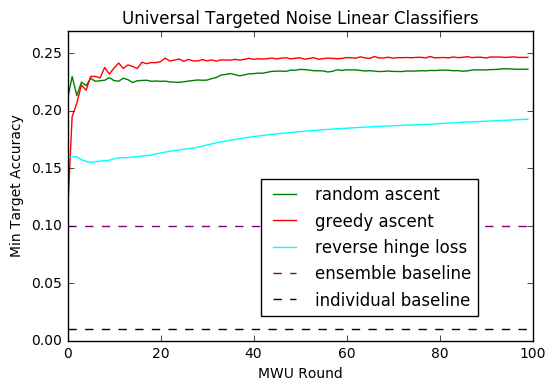

In [24]:
display_folders = ['random ascent', 'greedy ascent', 'reverse hinge loss']
colors = ["green", "red", "cyan"]
for i, ma in enumerate(max_acc_histories):
    plt.plot(range(100), ma, color=colors[i])
plt.plot(range(100), [ensemble_res] * 100, linestyle="--", color="purple")
plt.plot(range(100), [max_model] * 100, linestyle="--", color="black")
plt.legend(display_folders + ["ensemble baseline", "individual baseline"], loc="right", 
           bbox_to_anchor=(.9,.3), fontsize=12)
plt.title("Universal Targeted Noise Linear Classifiers")
plt.ylim((0,.27))
plt.ylabel("Min Target Accuracy")
plt.xlabel("MWU Round")